# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

rows = azdias.shape[0]
columns = azdias.shape[1]

print("Azdias number of rows: ", rows)
print("Azdias number of columns: ", columns)
azdias.head()

Azdias number of rows:  891221
Azdias number of columns:  85


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
rows = feat_info.shape[0]
columns = feat_info.shape[1]

print("Azdias number of rows: ", rows)
print("Azdias number of columns: ", columns)
feat_info.head()

Azdias number of rows:  85
Azdias number of columns:  4


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Below are the unique missing or unknown characters
# note the string characters X, XX, and missing ""
# str(feat_info.missing_or_unknown.unique())[1:-1]
str(feat_info.missing_or_unknown.unique())[1:-1]

"'[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]'"

In [6]:
def convert_missing_nan(df):
    '''
    Replace missing and unknown values specified by the feat_info data 
    with NaN values.

    INPUT: demographics dataframe with missing and unknown values
    OUTPUT: demographics dataframe with NaN values
    '''
    # Identify missing or unknown data values and convert them to NaNs.

    # iterate through each of the 85 columns
    for column_index in range(0, feat_info.shape[0]):
    
        # acquire a list of the columns missing or unknown indicator
        nan_values = feat_info.iloc[column_index, 3][1:-1].split(",")
        
        # properly type cast the missing or unknown indicator as string or integer
        for array_index in nan_values:
            if str(array_index) in ["X", "XX", ""]:
                array_index = str(array_index)
            else:
                array_index = int(array_index)

            # if demographics df column has a missing or unknown value replace with NaN
            df.iloc[:, column_index] = df.iloc[:, column_index].replace(array_index, np.nan)

    return df

In [7]:
azdias = convert_missing_nan(azdias)
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Per the formula of 1.5 times the interquartile range + the third quantile there are 6 outlier data points.  These outlier line shows the 6 outlier data points in the histogram.


In [8]:
def identify_column_missingness(df):
    '''
    Creates a dataframe identifying with attribute, information_level, 
    missing proportion, and whether the column is an outlier

    Input:
        df: the dataframe to analyze for column missingness
    Ouput:
        df_missing: the created dataframe representing the column missingness
        outliers: the calculated outlier value of the provided dataframe
    '''
    # build a list of nan proportions across the columns
    missing_list = df.isna().sum(axis=0) / df.shape[0]

    # identify outlier values per 1.5 times in IQR plus the 3rd quartile
    IQR = np.percentile(missing_list, q=75) - np.percentile(missing_list, q=25)
    outliers = np.percentile(missing_list, q=75) + 1.5 * (IQR)

    # build a dataframe of the missing proportion data for easy usage
    df_missing = pd.DataFrame({"attribute": feat_info.attribute,
                                "information_level": feat_info.information_level,
                                "miss_prop": missing_list.to_list()}, 
                                columns = ["attribute", "information_level", "miss_prop"])

    # create outlier column to indicate if column is an outlier
    df_missing["outlier"] = df_missing.miss_prop > outliers

    return df_missing, outliers

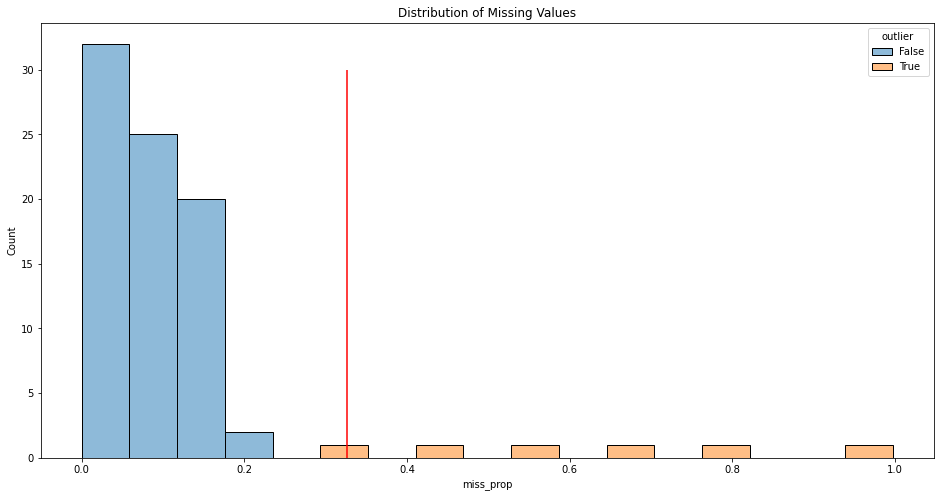

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias_missing, outliers = identify_column_missingness(azdias)

# plot Distribution of Missing Values
plt.figure(figsize=(16, 8))
plt.title("Distribution of Missing Values")
plt.vlines(outliers, ymin=0, ymax=30, colors="red")
sns.histplot(data=azdias_missing, x="miss_prop", hue="outlier");

Per the formula of 1.5 times the interquartile range + the third quantile there are 6 outlier data points.  You can see the row location of the outlier data point.  In addition, plotted the max outlier value located in the information level feature.  We can see that the person information level feature contains the max proportion of missing data folllowed by household and microcell_rr3.

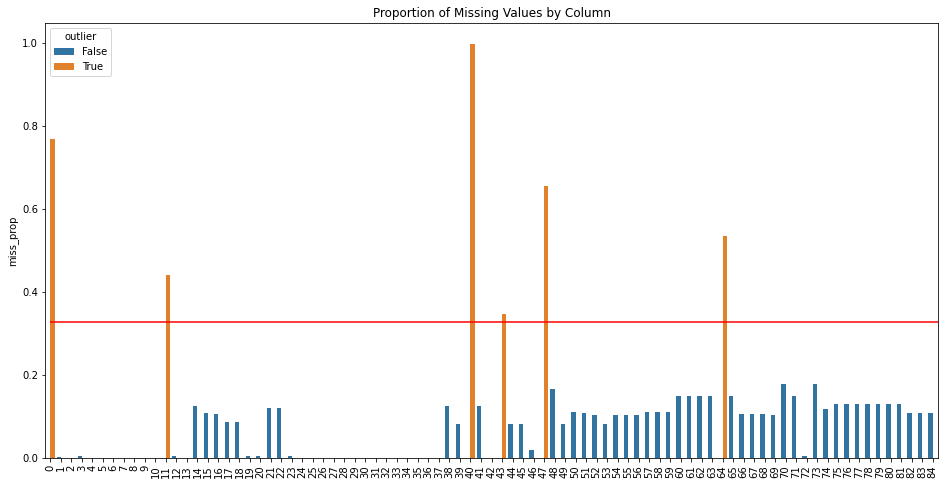

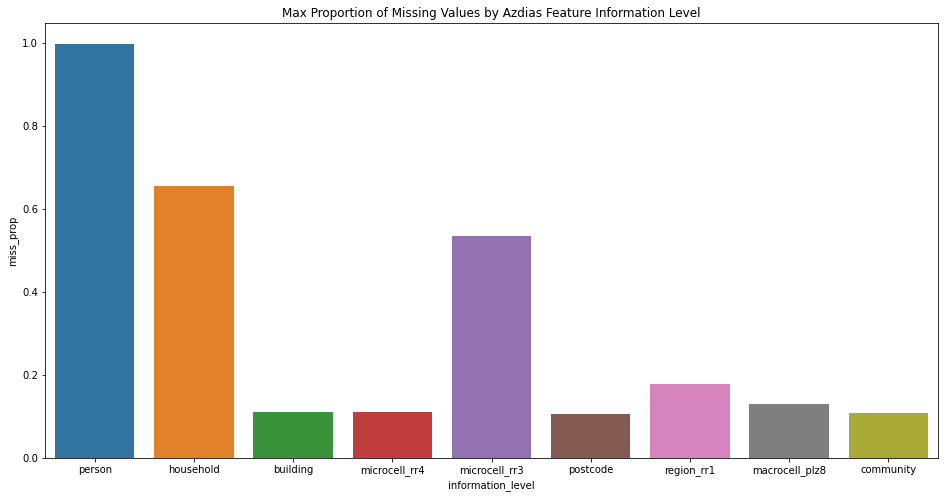

In [10]:
# Investigate patterns in the amount of missing data in each column.

# Proportion of Missing Values by Column
plt.figure(figsize=(16, 8))
plt.title("Proportion of Missing Values by Column")
plt.hlines(outliers, xmin=0, xmax=85, colors="red")
plt.xticks(rotation=90)
sns.barplot(data=azdias_missing, x=azdias_missing.index, y="miss_prop", ci=None, estimator=sum, hue="outlier");

# Max Proportion of Missing Values by Azdias Feature Information Level
plt.figure(figsize=(16, 8))
plt.title("Max Proportion of Missing Values by Azdias Feature Information Level")
sns.barplot(data=azdias_missing, x="information_level", y="miss_prop", estimator=max, ci=None);


Remove the following columns:
- AGER_TYPE: Best-ager typology
- GEBURTSJAHR: Year of birth
- TITEL_KZ: Academic title flag
- ALTER_HH: Birthdate of head of household
- KK_KUNDENTYP: Consumer pattern over past 12 months
- KBA05_BAUMAX: Most common building type within the microcell

Now all our columns are missing/unknown proportions are below 20%.

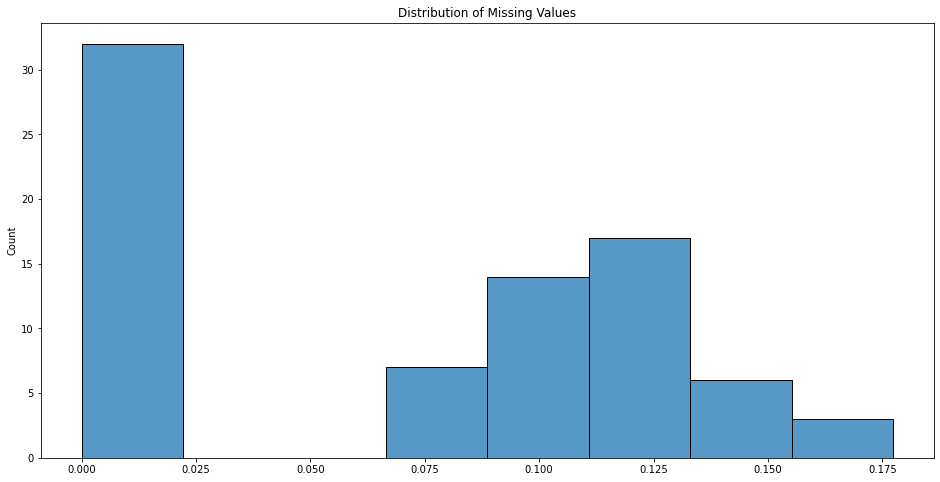

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# outlier columns
outlier_columns = azdias_missing.loc[azdias_missing.outlier == True, "attribute"]

azdias_clean = azdias.drop(outlier_columns, axis=1)

# build a list of missing/unknown proportions
missing_list = []
for column_index in range(0, azdias_clean.shape[1]):
    missing_prop = azdias_clean.iloc[:, column_index].isna().sum() / azdias_clean.shape[0]
    missing_list.append(missing_prop)

plt.figure(figsize=(16, 8))
plt.title("Distribution of Missing Values")
sns.histplot(missing_list);

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are six columns that contain missing values that exceed 20%.  The majority of the missing data was from the person information level type followed by household and microcell rr3.  The removed columns consist of: AGER_TYPE, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, and KBA05_BAUMAX.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
def identify_row_missingness(df, outlier_set=0.0):
    '''
    Creates a dataframe of the missing proportion and outlier values of the 
    passed in dataframe

    Input:
        df: dataframe to assess missing proportion and outlier values
        outlier_set: calculates the datframes outlier if set 0.0 otherwise the 
            outlier threshold is passed to the function
    Output: 
        df_miss_columns: dataframes of the missing proportion and outlier values
        outliers: calculated outlier threshold
    '''
    # calculate missing/unknown values in each row
    missing_rows = df.isna().sum(axis=1) / df.shape[1]

    # calculate an outlier threshold
    if outlier_set == 0.0:
        IQR = np.percentile(missing_rows, q=75) - np.percentile(missing_rows, q=25)
        outliers = np.percentile(missing_rows, q=75) + 1.5 * (IQR)
    else:
        outliers = outlier_set

    # build dataset to analyze missing data
    df_miss_columns = pd.DataFrame({"miss_prop": missing_rows}, 
                                        columns = ["miss_prop"])
    df_miss_columns["outlier"] = df_miss_columns.miss_prop > outliers

    return df_miss_columns, outliers

0.0949367088607595


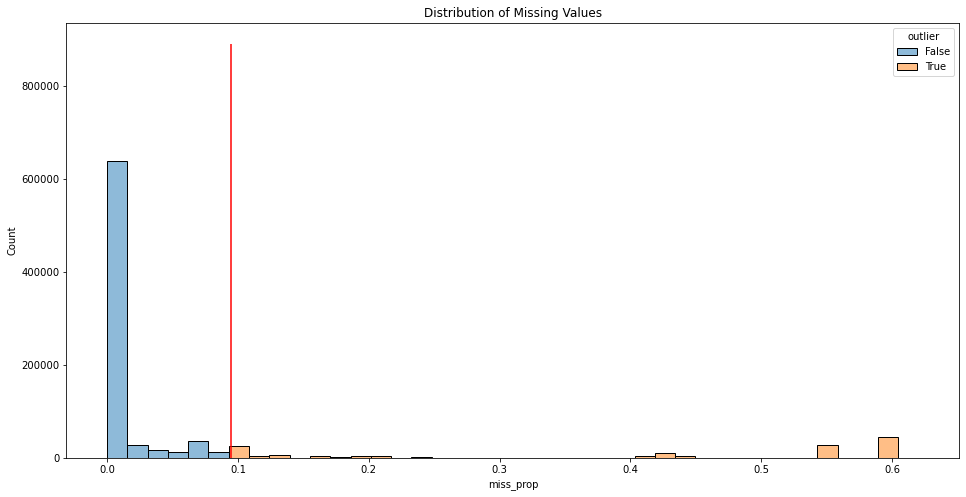

In [13]:
# How much data is missing in each row of the dataset?
azdias_miss_columns, outliers = identify_row_missingness(azdias_clean)
print(outliers)

# histogram plot of missing data distribution
plt.figure(figsize=(16, 8))
plt.title("Distribution of Missing Values")
plt.vlines(outliers, ymin=0, ymax=azdias_miss_columns.shape[0], colors="red")
sns.histplot(data=azdias_miss_columns, x="miss_prop", hue="outlier", bins=40);

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_rows_below_threshold = azdias_clean[azdias_miss_columns.outlier == False]
azdias_rows_above_threshold = azdias_clean[azdias_miss_columns.outlier == True]

In [15]:
feat_info.information_level.unique()

array(['person', 'household', 'building', 'microcell_rr4',
       'microcell_rr3', 'postcode', 'region_rr1', 'macrocell_plz8',
       'community'], dtype=object)

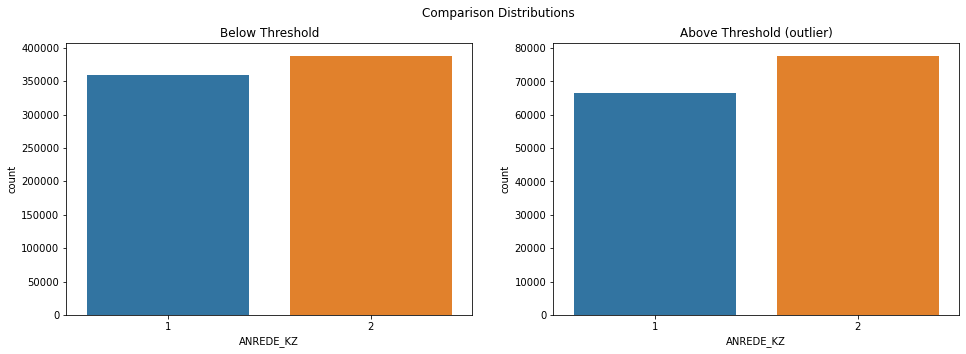

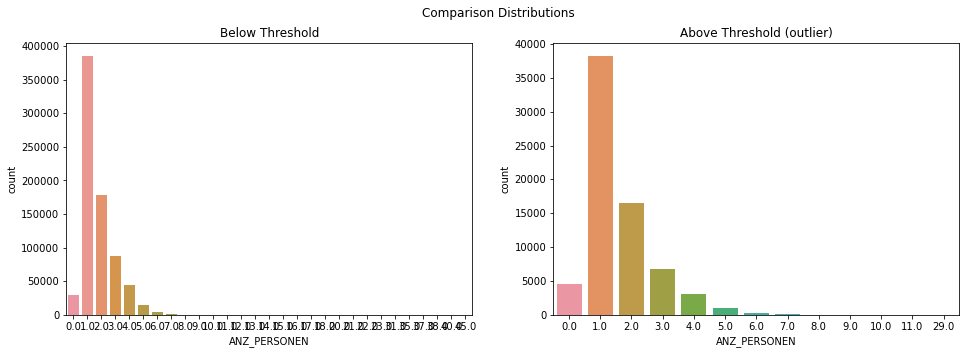

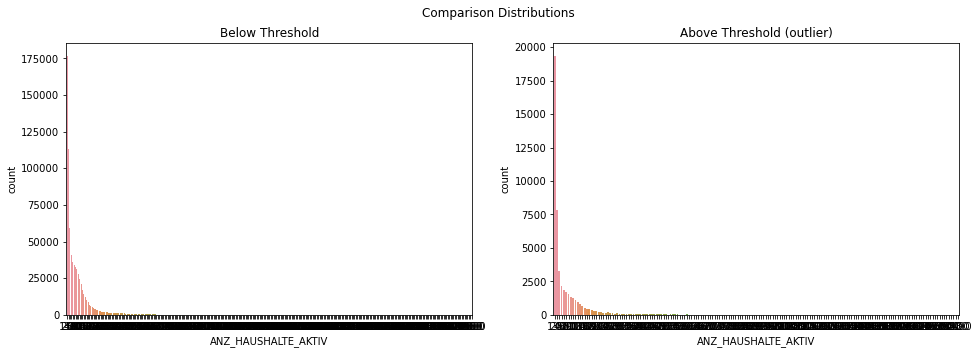

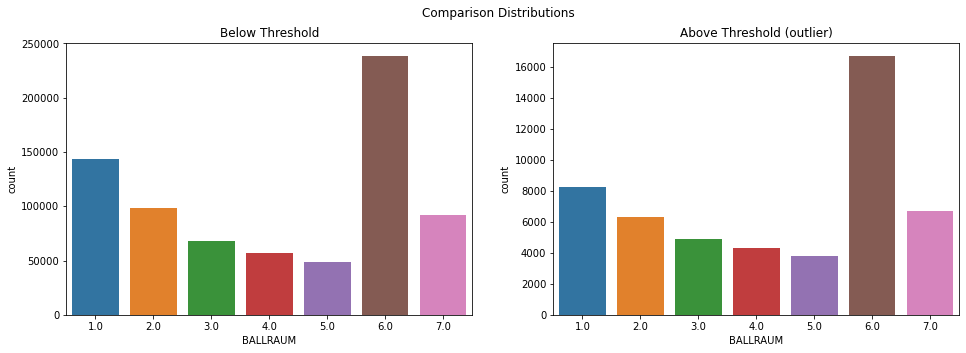

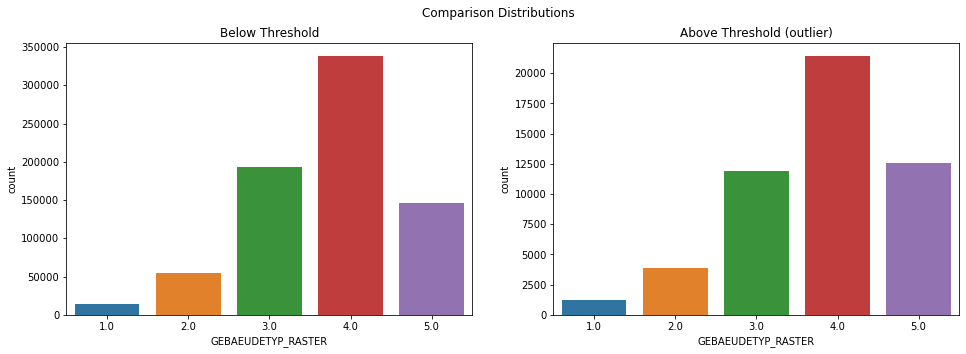

In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# select features with missing data points across the different feature information levels
non_missing_columns = azdias_missing[(azdias_missing.miss_prop == 0.0) & (azdias_missing.information_level == "person")].attribute.head(1)
non_missing_columns = non_missing_columns.append(azdias_missing[(azdias_missing.miss_prop <= 0.2) & (azdias_missing.information_level == "household")].attribute.head(1))
non_missing_columns = non_missing_columns.append(azdias_missing[(azdias_missing.miss_prop <= 0.2) & (azdias_missing.information_level == "building")].attribute.head(1))
non_missing_columns = non_missing_columns.append(azdias_missing[(azdias_missing.miss_prop <= 0.2) & (azdias_missing.information_level == "postcode")].attribute.head(1))
non_missing_columns = non_missing_columns.append(azdias_missing[(azdias_missing.miss_prop <= 0.2) & (azdias_missing.information_level == "region_rr1")].attribute.head(1))

# display plot comparison of 5 columns of row below and above the outlier threshold
# columns were selected across the a variety of information levels
for plot_col in non_missing_columns:
    f, axes = plt.subplots(1,2, figsize=(16,5))
    f.suptitle("Comparison Distributions")
    sns.countplot(ax=axes[0], x=plot_col, data=azdias_rows_below_threshold)
    axes[0].set_title("Below Threshold")
    sns.countplot(ax=axes[1], x=plot_col, data=azdias_rows_above_threshold)
    axes[1].set_title("Above Threshold (outlier)")


#### Discussion 1.1.3: Assess Missing Data in Each Row

A subset of rows below and above the outlier threshold were plotted across a variety of information level columns.  The plots of above and below the outlier threshold yielded a similar data distribution, therefore, removing the rows above the outlier threshold should result in a minimal and acceptable loss of information.


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [17]:
# How many features are there of each data type?
feat_info_clean = feat_info[~feat_info.loc[:, "attribute"].isin(outlier_columns)]
feature_count = feat_info_clean.groupby("type").agg("count").attribute

for f_idx, f_val in zip(feature_count.index, feature_count.values):
    print("There {} features in data type {}".format(f_val, f_idx))

There 18 features in data type categorical
There 6 features in data type mixed
There 6 features in data type numeric
There 49 features in data type ordinal


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [18]:
def return_categorical_df(df, redundant_list):
    '''
    Builds a categorical dataframe from the passed in dataframe argument with the following
    attributes: column name, counts, data types, binary, and encode columns.

    Input: 
        df: dataframe to utilize to build the categorical dataframe
        redundant_list: list redundant categorical variables
    Output: 
        categorical_df: categorical dataframe of the derived columns
    '''
    # acquires the columns names, counts of categories, and data types
    categorical_columns = feat_info_clean[feat_info_clean.type == "categorical"].attribute
    categorical_unique_counts = df.loc[:,categorical_columns].nunique()
    categorical_types = df.loc[:,categorical_columns].dtypes

    # builds a categorical dataframe of columns, counts, types, binary, and encode columns
    categorical_df = pd.DataFrame({"col": categorical_columns.values, 
                                "counts": categorical_unique_counts.values, 
                                "types": categorical_types.values}, 
                                columns = ["col", "counts", "types"], 
                                index=range(0,categorical_columns.shape[0]))
    categorical_df["binary"] = categorical_df.counts == 2
    categorical_df["redundant"] = categorical_df["col"].isin(redundant_list)
    categorical_df["encode"] = ~((categorical_df.binary == True) & (categorical_df.counts == 2) & (categorical_df.types != "O"))
    
    categorical_df.loc[((categorical_df["encode"] == True) & (categorical_df["redundant"] == True)), "encode"] = False

    return categorical_df

In [19]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_redundant = ["LP_FAMILIE_FEIN", "LP_STATUS_FEIN", "CAMEO_DEUG_2015", "CAMEO_DEU_2015"]

categorical_df = return_categorical_df(azdias_rows_below_threshold, categorical_redundant)

print("Categorical variables that are binary")
print(categorical_df[categorical_df.binary == True].col)

print("\nCategorical variables that multi-level")
print(categorical_df[categorical_df.binary == False].col)

print("\nCategorical variables that require encoding")
print(categorical_df[categorical_df.encode == True].col)

Categorical variables that are binary
0            ANREDE_KZ
4     GREEN_AVANTGARDE
11             SOHO_KZ
12            VERS_TYP
15         OST_WEST_KZ
Name: col, dtype: object

Categorical variables that multi-level
1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
5      LP_FAMILIE_FEIN
6      LP_FAMILIE_GROB
7       LP_STATUS_FEIN
8       LP_STATUS_GROB
9     NATIONALITAET_KZ
10         SHOPPER_TYP
13            ZABEOTYP
14         GEBAEUDETYP
16     CAMEO_DEUG_2015
17      CAMEO_DEU_2015
Name: col, dtype: object

Categorical variables that require encoding
1        CJT_GESAMTTYP
2            FINANZTYP
3      GFK_URLAUBERTYP
6      LP_FAMILIE_GROB
8       LP_STATUS_GROB
9     NATIONALITAET_KZ
10         SHOPPER_TYP
13            ZABEOTYP
14         GEBAEUDETYP
15         OST_WEST_KZ
Name: col, dtype: object


In [20]:
def one_hot_encode(df, column_name):
    '''
    One hot encodes the passed in dataframe in accordance with the passed
    in column_name variable.  Once one hot encoded features are created, the
    original column variable is dropped.

    Input: 
        df: dataframe to be one hot encoded
        column_name: column name to be one hot encoded
    Oupt:
        df: returned one hot encoded dataframe
    '''
    one_hot_result = pd.get_dummies(column_name, prefix=column_name.name)
    df = pd.concat([df, one_hot_result], axis=1)
    df.drop([column_name.name], axis=1, inplace=True)
    return df

In [21]:
# Re-encode categorical variable(s) to be kept in the analysis.

# loops through the specified columns that require encoding and one hot encodes them
azdias_clean_encode = azdias_rows_below_threshold
for cat_column in categorical_df[categorical_df.encode == True].col:
    azdias_clean_encode = one_hot_encode(azdias_clean_encode, azdias_clean_encode.loc[:, cat_column])

# drop the redundant columns
azdias_clean_encode.drop(categorical_redundant, axis=1, inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

The categorical non-binary and binary non-numeric data types that represented multi-level data types were one hot encoded with the exception of redundant columns.  These features were encoded, since machine learning algorithms cannot execute on non-numeric categorical variables.  Additionally, these categorical variables were encoded to enrich the dataset.  The binary categorical features with two values were left unchanged, since it is in an acceptable format for unsupervised modeling.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [22]:
azdias_clean_encode.PRAEGENDE_JUGENDJAHRE.unique()

array([14., 15.,  8.,  3., 10., 11.,  9.,  6.,  4., nan,  5.,  2.,  1.,
       12., 13.,  7.])

In [23]:
def feature_engineer_PRAEGENDE_JUGENDJAHRE(df):
    '''
    The passed in dataframe with mixed data type PRAEGENDE_JUGENDJAHRE is split up into 
    two features decade and movement.  PRAEGENDE_JUGENDJAHRE is dropped from the datframe.
    
    Input:
        df: passed in dataframe with mixed column PRAEGENDE_JUGENDJAHRE 
    Output:
        df: returned dataframe with two new features decade and movement with PRAEGENDE_JUGENDJAHRE dropped
    '''
    # create dictionary of the decade values
    decade_dict = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}

    # encode Mainstream as 1 and Avantgarde as 0
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    # create decade and movement features with dictionary mapping values
    df["decade"] = df["PRAEGENDE_JUGENDJAHRE"].map(decade_dict)
    df["movement"] = df["PRAEGENDE_JUGENDJAHRE"].map(movement_dict)

    # drop columns since we featured engineered new columns
    df.drop("PRAEGENDE_JUGENDJAHRE", axis=1, inplace=True)

    return df

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_clean_encode = feature_engineer_PRAEGENDE_JUGENDJAHRE(azdias_clean_encode)

In [25]:
def feature_engineer_CAMEO_INTL_2015(df):
    '''
    The passed in dataframe with mixed data type CAMEO_INTL_2015 is split up into 
    two features wealth and life_stage.  CAMEO_INTL_2015 is dropped from the datframe.
    
    Input:
        df: passed in dataframe with mixed column CAMEO_INTL_2015 
    Output:
        df: returned dataframe with two new features wealth and life_stage with CAMEO_INTL_2015 dropped
    '''
    # create the wealth feature from the mixed data type
    wealth_list = []
    for col_val in df["CAMEO_INTL_2015"]:
        if type(col_val) == str:
            wealth_list.append(col_val[0:1])
        else:
            wealth_list.append(np.nan)
    df["wealth"] = wealth_list

    # create the life_stage feature from the mixed data type
    life_stage_list = []
    for col_val in df["CAMEO_INTL_2015"]:
        if type(col_val) == str:
            life_stage_list.append(col_val[1:2])
        else:
            life_stage_list.append(np.nan)
    df["life_stage"] = life_stage_list

    # drop columns since we featured engineered new columns
    df.drop("CAMEO_INTL_2015", axis=1, inplace=True)

    return df

In [26]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_clean_encode = feature_engineer_CAMEO_INTL_2015(azdias_clean_encode)

In [27]:
# contains data to be enriched by one hot encoding
mixed_types_one_hot = ["WOHNLAGE", "PLZ8_BAUMAX"]

# drop features
# LP_LEBENSPHASE_GROB - redundant mixed data type column with its data already included by life_stage 
# and LP_FAMILIE_GROB::rough scale
mixed_redundant_drop = ["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"]

# one hot encode remaining mixed types
for cat_column in mixed_types_one_hot:
    azdias_clean_encode = one_hot_encode(azdias_clean_encode, azdias_clean_encode.loc[:, cat_column])

# drop redundant mixed types
azdias_clean_encode.drop(mixed_redundant_drop, axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

Mixed data types PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were encoded into separate features decade, movement, wealth, and life stage.  Mixed data types LP_LEBENSPHASE_FEIN and  LP_LEBENSPHASE_GROB were dropped, since they contain redundant data to existing features.  Mixed data types WOHNLAGE and PLZ8_BAUMAX were one hot encoded to further enrich the data set for modeling.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


No further re-engineering tasks are rquired.

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


No further tasks are required.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df, col_list, row_outlier, categorical_redundant, hard_code_flag=False):
    '''
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df: Demographics DataFrame
        col_list: list of columns that require removal
        row_outlier: row missingness outlier threshold
        categorical_redundant: categorical redundant columns that should be dropped
        hard_code_flag: if true indicates the user will explicitly pass in the
            columns to be removed and row outliers
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''

    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, …
    df = convert_missing_nan(df)

    # remove selected columns
    if hard_code_flag:
        # manually remove columns
        outlier_columns = col_list
    
    # otherwise missing columns will be detected and removed
    else:
        azdias_missing = identify_column_missingness(df)
        outlier_columns = azdias_missing.loc[azdias_missing.outlier == True, "attribute"]
    
    # drop outlier columns
    df.drop(outlier_columns, axis=1, inplace=True)

    # remove selected columns
    if hard_code_flag:       
        # manually set outlier value
        azdias_miss_columns, outliers = identify_row_missingness(df, outlier_set=row_outlier)
    
    # otherwise missing row outliers will be detected
    else:
        azdias_miss_columns, outliers = identify_row_missingness(df)

    # remove selected rows below a specified outlier value
    df = df[azdias_miss_columns.outlier == False]

    # select, re-encode, and engineer column values.
    # encode categorical columns
    categorical_df = return_categorical_df(df, categorical_redundant)

    # one hot encode the categorical columns
    for cat_column in categorical_df[categorical_df.encode == True].col:
        df = one_hot_encode(df, df.loc[:, cat_column])
    
    # drop redundant categorical columns
    df.drop(categorical_redundant, axis=1, inplace=True)

    # feature engineer the mixed data type columns
    df = feature_engineer_PRAEGENDE_JUGENDJAHRE(df)
    df = feature_engineer_CAMEO_INTL_2015(df)

    # identify the additional mixed data types required for one hot encoding 
    # and dropping
    mixed_types_one_hot = ["WOHNLAGE", "PLZ8_BAUMAX"]
    mixed_redundant_drop = ["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB"]

    # one hot encode remaining mixed types
    for cat_column in mixed_types_one_hot:
        df = one_hot_encode(df, df.loc[:, cat_column])

    # drop redundant mixed types
    for cat_column in mixed_redundant_drop:
        df.drop(cat_column, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# impute the dataset's missing values with a median value
imputer = SimpleImputer(missing_values=np.nan, strategy="median")
azdias_final = imputer.fit_transform(azdias_clean_encode)

In [32]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_final_scaled = scaler.fit_transform(azdias_final)

### Discussion 2.1: Apply Feature Scaling

A downstream an unsupervised KMeans algorithm will be applied to the dataset.  This algorithm applies a distance cost function between columns and centroids.  It is required that all features are specified on the same scale otherwise the model will not return meaningful results.  Therefore, the dataset was scaled to a standard normally distributed dataset by setting the mean to zero and variance to 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [33]:
# Apply PCA to the data.
pca = PCA(random_state=123)
azdias_pca = pca.fit_transform(azdias_final_scaled)

In [34]:
def scree_plot(pca):
    '''
    Creates a scree plot of the cummlative variance explained by incrementally 
    increasing the number of principal components 
    
    INPUT: 
        pca - the principal component dataset            
    OUTPUT:
            None
    '''
    
    # plot the cummlative variance explained by the principal components
    plt.figure(figsize=(16, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

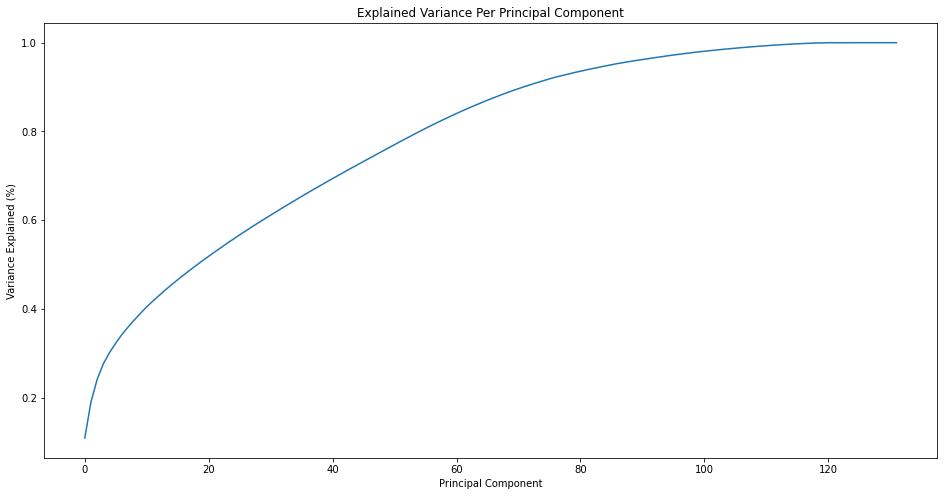

In [35]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca) #Use the scree plot to answer the next question

In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.

# use numpy to efficiently identify the cummlative PCA components to explain
# at least 90% of the data
pca_cum_var = pca.explained_variance_ratio_.cumsum()
n_comp_90 = np.where([pca_cum_var>.90])[1][0]
total_cum_var = pca_cum_var[n_comp_90]
print("{} PCA components explains {} of the data".format(n_comp_90, total_cum_var))

# apply PCA with the selected number of components to keep
pca = PCA(n_components=n_comp_90, random_state=123)
azdias_pca = pca.fit_transform(azdias_final_scaled)

71 PCA components explains 0.9011483494397038 of the data


### Discussion 2.2: Perform Dimensionality Reduction

It was decided to keep a sufficient quantity of principal components to explain at least 90 percent of the dataset.  We are keeping 71 principal components, which should explain approximately 90 percent of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [37]:
def map_pca(df, n_principal_component):
    '''
    Takes the principal component dataframe and selected principal component and creates a 
    bar plot of the top 5 most positive and top negatives principle component features

    Input:
        df: principal component dataframe
        n_princpal_component: specified prinicpal component
    Output:
        None
    '''
    # create a dataframe of the principle components mapped to the feature column name
    pca_mapped_weights = pd.DataFrame(pca.components_, columns=df.columns.to_list())

    # top 2 positive principle components
    pos_comp = pca_mapped_weights.iloc[n_principal_component].sort_values(ascending=False).head(5)

    # top 2 positive principle components
    neg_comp = pca_mapped_weights.iloc[n_principal_component].sort_values(ascending=True).head(5)
    
    plt.figure(figsize=(16, 8))
    plt.bar(pos_comp.index, pos_comp.values)
    plt.bar(neg_comp.index, neg_comp.values)
    plt.xticks(rotation = 45)
    plt.title("Max Features Weights for component number {}".format(n_principal_component+1))


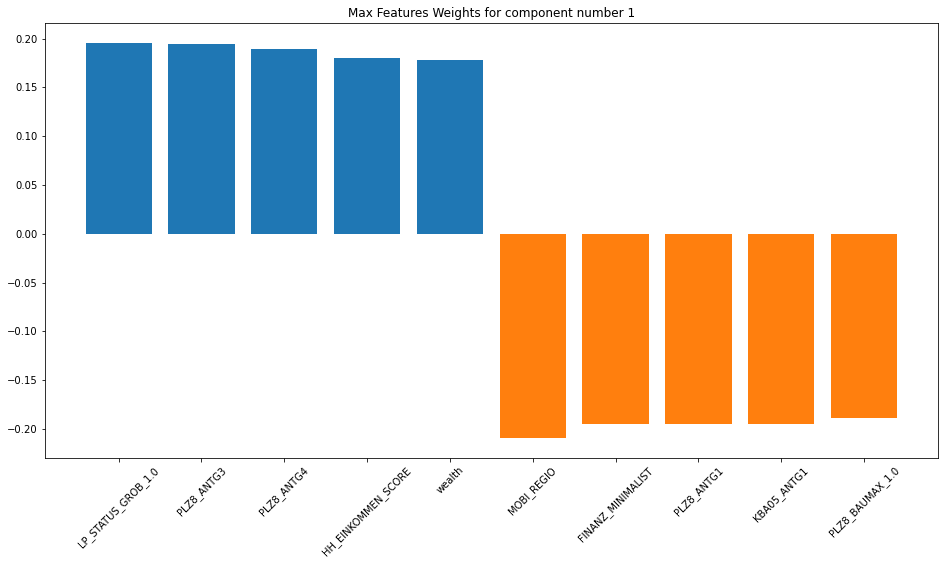

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_pca(azdias_clean_encode, 0)

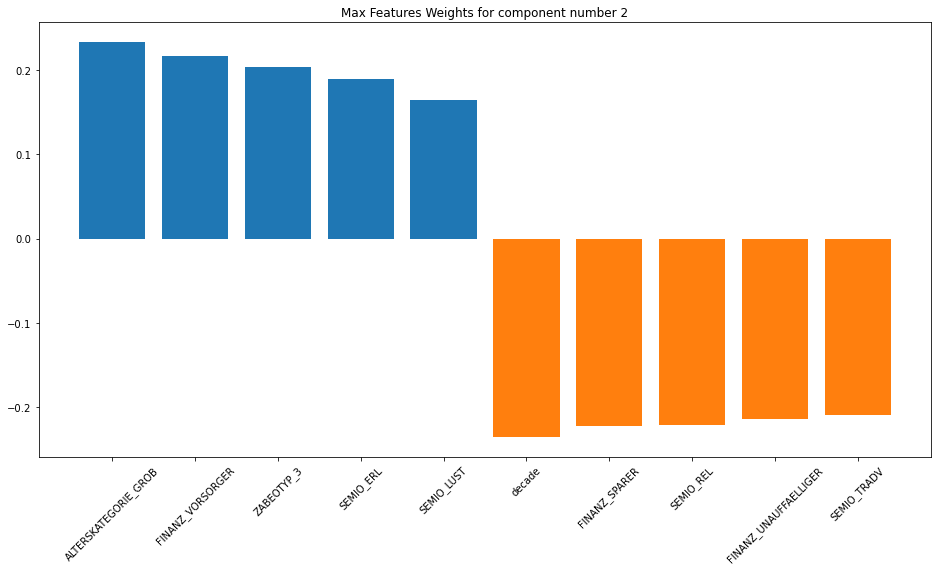

In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_pca(azdias_clean_encode, 1)

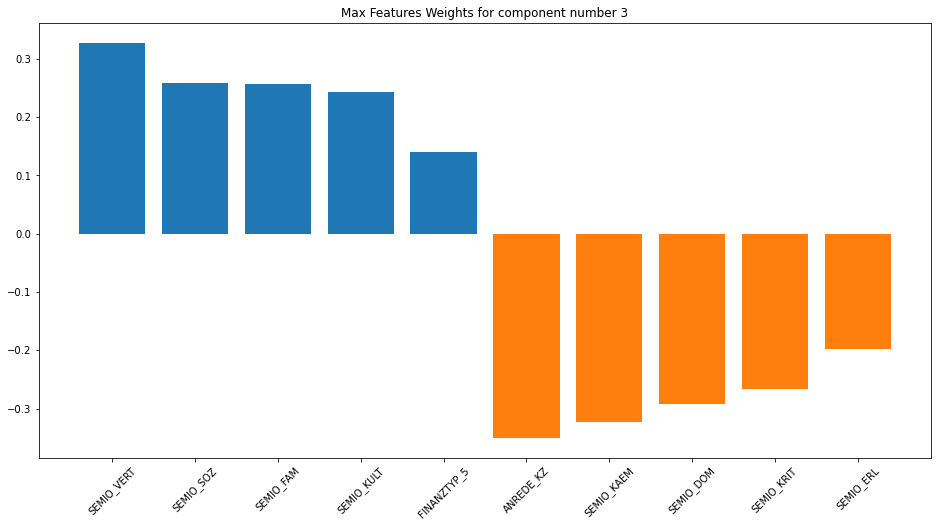

In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
map_pca(azdias_clean_encode, 2)

### Discussion 2.3: Interpret Principal Components

The top 5 most positively and negatively correlated features from the top three principal components were plotted.  

**First Component**

The first principal component displayed a high positive correlation to low-income earners (LP_STATUS_GROB_1.0), the number of 6-10 family houses in the PLZ8 region (PLZ8_ANTG3), and the number of 6-10 family houses in the PLZ8 region (PLZ8_ANTG4).  The first principal component displayed a high negative correlation to movement patterns (MOBI_REGIO), low financial interests (FINANZ_MINIMALIST), and the number of 1-2 family houses in the PLZ8 region (PLZ8_ANTG1).

**Second Component**

The second principal component displayed a high positive correlation to estimated age (ALTERSKATEGORIE_GROB), financially prepared (FINANZ_VORSORGER), and fair energy consumption (ZABEOTYP_3).  The second principal component displayed a high negative correlation to decade, money saver (FINANZ_SPARER), and religious (SEMIO_REL).

**Third Component**

Lastly, the third principal component displayed a high positive correlation to dreamful (SEMIO_VERT), the family minded (SEMIO_FAM), and socially minded (SEMIO_SOZ).  The third principal component displayed a high negative correlation to gender (ANREDE_KZ), combative attitude (SEMIO_KAEM), and dominant minded (SEMIO_DOM).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
def calculate_kmeans_score(df, left_range, right_range):
    '''
    Computes the average within-cluster distance between the provided 
    cluster range

    Input:
        df: the dataframe to calculate the average within-cluster distance
        left_range: left cluster number range
        right_range: right cluster number range
    Output:
        kmeans_score: calculate average within-cluster distances

    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity Intro to Machine Learning Nano Degree Training material.
    '''
    # create a dictionary of cluster number keys and the 
    # computed average within-cluster distances as values
    # computer between 5 and 20 clusters
    kmeans_score = {}
    for i in range(left_range, right_range):
        kmeans_score[i] = abs(KMeans(i, random_state=123).fit(df).score(df))
    return kmeans_score

In [42]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...   
    # compute the average within-cluster distances.

kmeans_score = calculate_kmeans_score(azdias_pca, 5, 20)
kmeans_score

{5: 71964539.49073653,
 6: 70581519.5041567,
 7: 69369695.05319911,
 8: 68372871.33302838,
 9: 67639732.5640188,
 10: 66989624.17447269,
 11: 66344058.38555697,
 12: 65835316.06097336,
 13: 65276333.70915776,
 14: 64795348.031667255,
 15: 64384375.315692745,
 16: 63823659.6646826,
 17: 63192126.16809357,
 18: 63010233.2059779,
 19: 62580591.54820351}

In [43]:
def kmeans_scree_plot(kmeans_score):
    '''
    Plots the within-cluster distances across the cluster numbers

    Input:
        kmeans_score: calculated average within-cluster distances
    Output:
        None
    Code Attribution:
        This function contains code that was updated and leveraged from the 
        Udacity Intro to Machine Learning Nano Degree Training material.
    '''
    plt.figure(figsize=(16, 8))
    plt.plot(kmeans_score.keys(), kmeans_score.values(), linestyle='--', marker='o', color='b');
    plt.xlabel('K');
    plt.ylabel('SSE');
    plt.title('SSE vs. K');

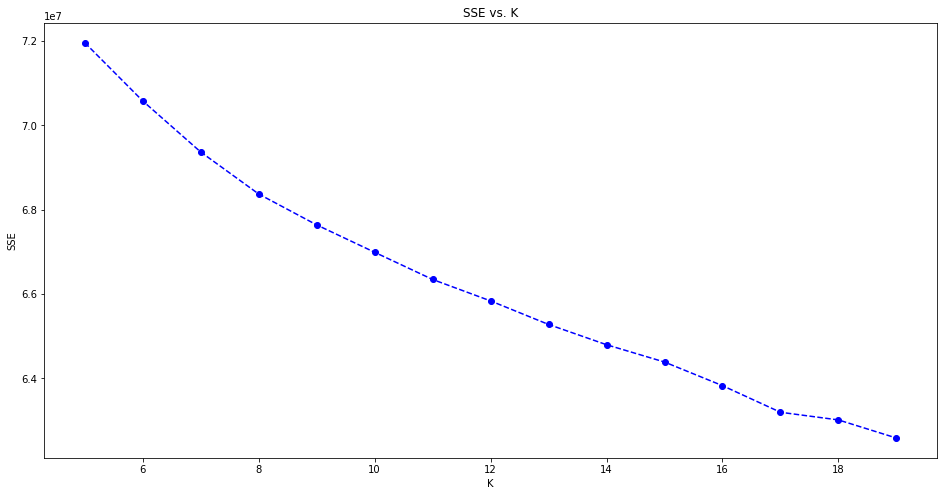

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# plot the within-cluster distances across the cluster numbers and identify the elbow
kmeans_scree_plot(kmeans_score)

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# elbow appears to be at cluster 18 in the above scree plot
n_clusters = 17
kmeans_object = KMeans(n_clusters, random_state=123)
kmeans_model = kmeans_object.fit(azdias_pca)
azdias_kmeans = kmeans_model.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

The within cluster distances were plotted across the number of computed clusters.  The plot appears to show an elbow at 17 clusters.  Therefore, we will proceed segment the population into 17 different clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [46]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [47]:
outlier_columns

0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: attribute, dtype: object

In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers, col_list=outlier_columns, row_outlier=outliers, categorical_redundant=categorical_redundant, hard_code_flag=True)

In [49]:
# when one hot encoding the customers dataset it appears there was no 5 data entry for
## GEBAEUDETYP
cust_columns = customers_clean.columns.to_list()
azdias_columns = azdias_clean_encode.columns.to_list()

list(set(azdias_columns) - set(cust_columns))

['GEBAEUDETYP_5.0']

In [50]:
# add the missing one hot encoding to the customers dataset to get the datasets to match
customers_clean["GEBAEUDETYP_5.0"] = 0

In [51]:
# total missing columns, null values need to be imputed
customers_clean.isnull().sum().sum()

44330

In [52]:
# impute customer data
customers_imputed = imputer.transform(customers_clean)

# scale customer data
customers_scaled = scaler.transform(customers_imputed)

# apply PCA to the customer data
customers_pca = pca.transform(customers_scaled)

# predict the cluster labels for the customer data
customers_kmeans = kmeans_object.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

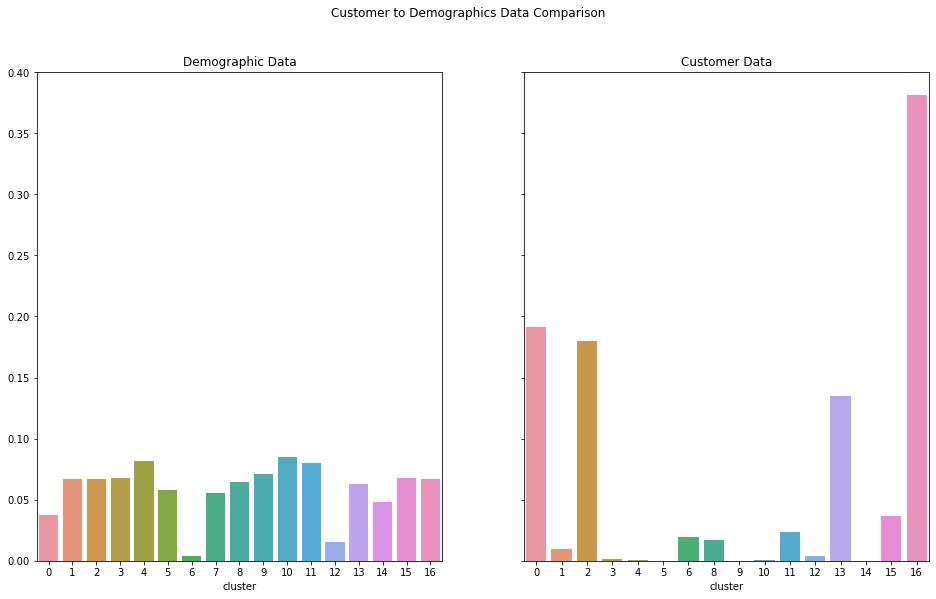

In [53]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# create a proportion dataframe for the demographic data
azdias_kmeans_df = pd.DataFrame(dict(cluster = azdias_kmeans))
azdias_prop = azdias_kmeans_df["cluster"].groupby(azdias_kmeans_df["cluster"]).count() / len(azdias_kmeans_df)

# create a proportion dataframe for the customer data
customers_kmeans_df = pd.DataFrame(dict(cluster = customers_kmeans))
customers_prop = customers_kmeans_df["cluster"].groupby(customers_kmeans_df["cluster"]).count() / len(customers_kmeans_df)

# compare the customer and demographic data
f, axes = plt.subplots(1,2, figsize=(16,9), sharey=True)
f.suptitle("Customer to Demographics Data Comparison")
sns.barplot(x=azdias_prop.index, y=azdias_prop.values, label="demo", ax=axes[0])
axes[0].set_title("Demographic Data")
sns.barplot(x=customers_prop.index, y=customers_prop.values, label="cust", ax=axes[1])
axes[1].set_title("Customer Data");

In [54]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# identify the most overrepresented customer data
delta_prop = customers_prop - azdias_prop
overrepresented_cluster = delta_prop[delta_prop == delta_prop.max()].index[0]

print("The most overrepresented cluster of customer data is cluster ", overrepresented_cluster)

The most overrepresented cluster of customer data is cluster  16


In [55]:
# most overrepresented features
overrepresented = scaler.inverse_transform(pca.inverse_transform(kmeans_object.cluster_centers_[overrepresented_cluster]))
pd.Series(overrepresented, index=customers_clean.columns).sort_values(ascending=False).head()

MIN_GEBAEUDEJAHR    1992.811306
KBA13_ANZAHL_PKW     691.026103
movement              64.310620
WOHNDAUER_2008         8.628136
SEMIO_VERT             6.249240
dtype: float64

In [56]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# identify the most underrepresented customer data
underrepresented_cluster = delta_prop[delta_prop == delta_prop.min()].index[0]

print("The most underrepresented cluster of customer data is cluster ", underrepresented_cluster)

The most underrepresented cluster of customer data is cluster  10


In [57]:
# most underrepresented features
underrepresented = scaler.inverse_transform(pca.inverse_transform(kmeans_object.cluster_centers_[underrepresented_cluster]))
pd.Series(underrepresented, index=customers_clean.columns).sort_values(ascending=False).head()

MIN_GEBAEUDEJAHR       1992.435109
KBA13_ANZAHL_PKW        515.311833
movement                 86.795328
ANZ_HAUSHALTE_AKTIV      13.715793
WOHNDAUER_2008            7.230765
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

The overrepresented customer cluster segments popular in the demographic data are clusters 16 and 0.   Within these clusters the following features have a positive correlation is a dreamful personality and demographic characteristics describing the building, microcell, and household.  The demographics representing this overrepresented customer cluster segment should be targeted for marketing to maximize efficiencies in acquiring company customers and hopefully sales.

The underrepresented customer cluster segments unpopular in the demographic data are clusters 10 and 9.   Within these clusters the following features have a positive correlation with demographic characteristics describing the building, microcell, and household.  The demographics representing this underrepresented customer cluster segment should not be targeted for marketing to minimize wasted marketing funds.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.